In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
tf.__version__

'2.17.0'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1728643070.935796    3146 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728643071.592292    3146 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728643071.592398    3146 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728643071.596093    3146 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728643071.596158    3146 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Reading Data

In [16]:
PATH = os.getcwd()
data_dir = PATH + "/data/classification_data"
print(data_dir)

D:\major_project_1\model/data/classification_data


In [17]:
batch_size = 32
img_height = 528
img_width = 652

In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    seed=123,
    batch_size=batch_size,
)

Found 1600 files belonging to 8 classes.
Using 1280 files for training.


In [19]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    seed=123,
    batch_size=batch_size,
)

Found 1600 files belonging to 8 classes.
Using 320 files for validation.


In [20]:
class_names = train_ds.class_names
print(class_names)

['Anwar Ratool', 'Chaunsa (Black)', 'Chaunsa (Summer Bahisht)', 'Chaunsa (White)', 'Dosehri', 'Fajri', 'Langra', 'Sindhri']


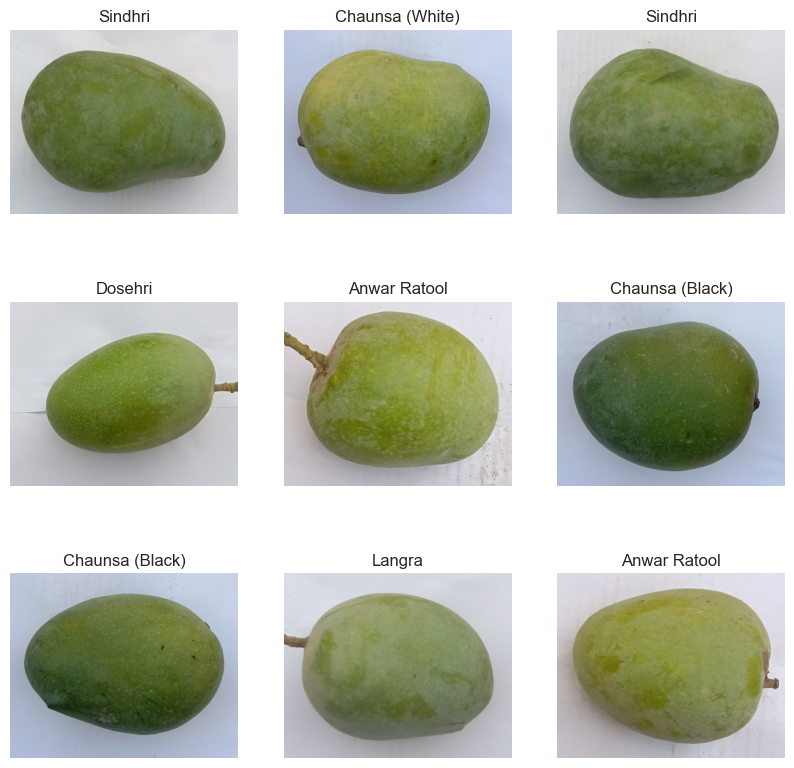

In [21]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        aax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')


In [22]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 528, 652, 3)
(32,)


In [23]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)
print(tf.data.experimental.cardinality(val_ds))
print(tf.data.experimental.cardinality(test_ds))

tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


Preprocessing Images

In [24]:
def preprocess_image(image, label):
    image = tf.image.resize(image, [224, 224], method=tf.image.ResizeMethod.BILINEAR, antialias=True)
    return image, label

In [25]:
train_ds = train_ds.map(preprocess_image)
val_ds = val_ds.map(preprocess_image)
test_ds = test_ds.map(preprocess_image)

In [26]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Model Declaration

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [16]:
base_model = tf.keras.applications.MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
len(list(base_model.layers))

187

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(8)

In [18]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [20]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         7,688 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,004,040 (11.46 MB)

 Trainable params: 7,688 (30.03 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [22]:
initial_epochs = 10

In [23]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    )

Epoch 1/10


2024-10-11 16:08:31.285208: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
W0000 00:00:1728643111.510780    3250 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728643111.594304    3250 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728643111.614349    3250 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728643111.634831    3250 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728643111.655355    3250 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728643111.685241    3250 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728643111.711768    3250 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728643111.734642    3250 gpu_t

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.2184 - loss: 2.3402

2024-10-11 16:08:37.742813: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 132194560 bytes after encountering the first element of size 132194560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.2204 - loss: 2.3317 - val_accuracy: 0.5469 - val_loss: 1.4140
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.5449 - loss: 1.3870 - val_accuracy: 0.7539 - val_loss: 1.0416
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.6708 - loss: 1.0010 - val_accuracy: 0.7773 - val_loss: 0.8597
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.7472 - loss: 0.8151 - val_accuracy: 0.7773 - val_loss: 0.7638
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.8171 - loss: 0.6647 - val_accuracy: 0.7930 - val_loss: 0.6735
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.8583 - loss: 0.5600 - val_accuracy: 0.8438 - val_loss: 0.6103
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.8740 - loss: 0.5194 - val_accuracy: 0.8594 - val_loss: 0.5653
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.8669 - loss: 0.4738 - val_accuracy: 0.9062 - val_loss: 

Tuning Model

In [24]:
base_model.trainable = True

fine_tune_at = 180

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [25]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
    metrics=['accuracy'],
)

In [26]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         7,688 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,004,040 (11.46 MB)

 Trainable params: 317,128 (1.21 MB)

 Non-trainable params: 2,686,912 (10.25 MB)

In [27]:
fine_tune_epochs = 30
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,)

Epoch 10/40
 1/40 ━━━━━━━━━━━━━━━━━━━━ 4:14 7s/step - accuracy: 0.6250 - loss: 0.8639

W0000 00:00:1728643177.954035    3252 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728643177.957649    3252 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728643177.960231    3252 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728643177.962795    3252 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728643177.969844    3252 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728643177.972730    3252 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728643177.975922    3252 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728643177.979161    3252 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728643177.990010    3252 gp

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.6823 - loss: 0.8963 - val_accuracy: 0.7969 - val_loss: 0.5515
Epoch 11/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9052 - loss: 0.3142 - val_accuracy: 0.7578 - val_loss: 0.5899
Epoch 12/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9087 - loss: 0.2740 - val_accuracy: 0.7656 - val_loss: 0.5671
Epoch 13/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9236 - loss: 0.2373 - val_accuracy: 0.7812 - val_loss: 0.5522
Epoch 14/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9400 - loss: 0.2174 - val_accuracy: 0.8008 - val_loss: 0.5200
Epoch 15/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9440 - loss: 0.1990 - val_accuracy: 0.8164 - val_loss: 0.4907
Epoch 16/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9609 - loss: 0.1562 - val_accuracy: 0.8086 - val_loss: 0.4749
Epoch 17/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9532 - loss: 0.1523 - val_accuracy: 0.8555 - val

2024-10-11 16:11:47.954617: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 132194560 bytes after encountering the first element of size 132194560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Predictions:
 [4 4 1 5 2 2 3 5 2 4 4 3 3 0 4 7 7 3 3 1 6 3 6 2 7 2 6 0 2 6 6 0]
Labels:
 [4 4 1 5 2 2 3 5 2 4 4 3 3 0 4 7 7 3 3 1 6 3 6 2 7 2 6 0 2 6 6 0]


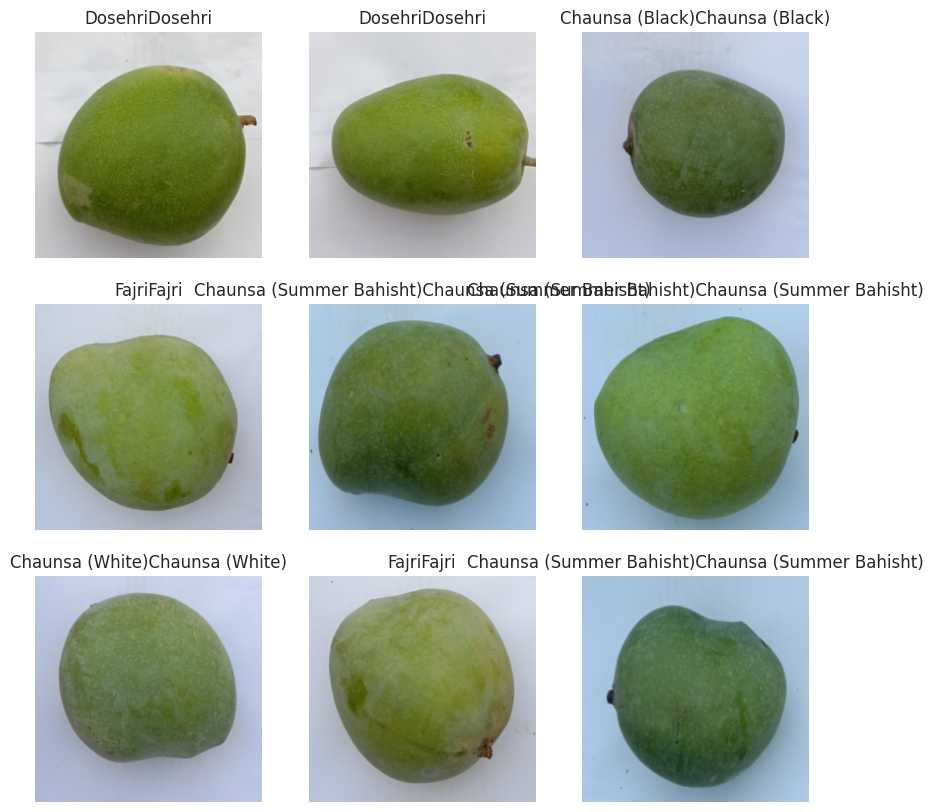

In [28]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)


predictions = tf.nn.softmax(predictions, axis=-1)
predicted_classes = tf.argmax(predictions, axis=-1)

print('Predictions:\n', predicted_classes.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predicted_classes[i]] + class_names[label_batch[i]])
    plt.axis("off")

plt.show()

ValueError: not enough values to unpack (expected 2, got 1)

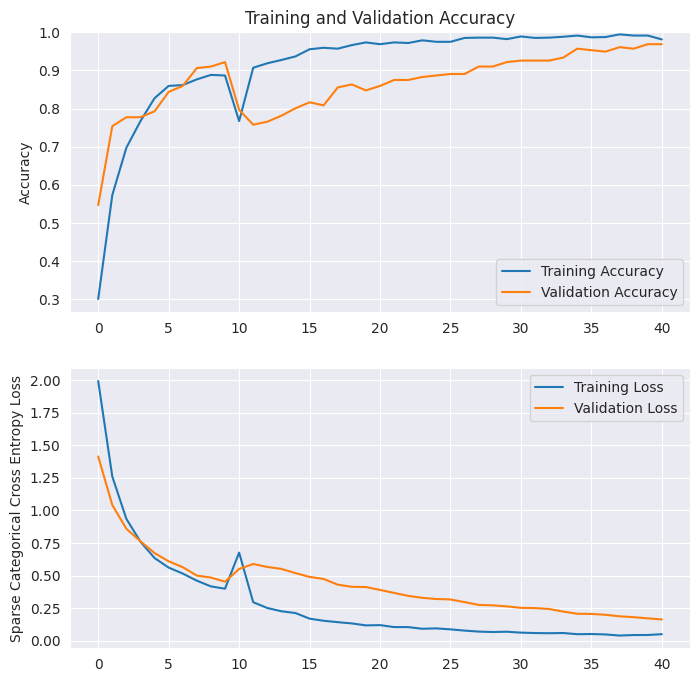

In [29]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim(min(plt.ylim()), 1)
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Sparse Categorical Cross Entropy Loss')
plt.ylim([[0, 1.0]])
plt.title("Training and Validation Loss")
plt.xlabel('epoch')
plt.show()

In [30]:
# Confusion Matrix
cm = tf.math.confusion_matrix(label_batch, predicted_classes)

In [31]:
cm

<tf.Tensor: shape=(8, 8), dtype=int32, numpy=
array([[3, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 6, 0, 0, 0, 0, 0],
       [0, 0, 0, 6, 0, 0, 0, 0],
       [0, 0, 0, 0, 5, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 5, 0],
       [0, 0, 0, 0, 0, 0, 0, 3]], dtype=int32)>

In [32]:
cm_np = cm.numpy()

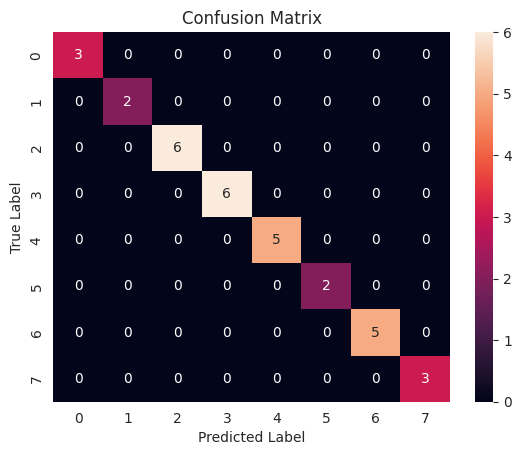

In [33]:
sns.heatmap(cm_np, annot=True)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Confusion Matrix")
plt.show()

In [34]:
model.save(os.getcwd() + '/models/classification.keras')

In [3]:
m2 = tf.keras.models.load_model('saved_models/classification.keras')
# m2.layers[-2].trainable = False

In [41]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

num_batches_test = 6
batch_size = 32

total_predictions = []
total_labels = []

for _ in range(num_batches_test):
    # noinspection PyUnresolvedReferences
    image_batch, label_batch = t_ds.as_numpy_iterator().next()
    predictions = m2.predict_on_batch(image_batch)
    predictions = tf.nn.softmax(predictions, axis=-1)
    predicted_classes = tf.argmax(predictions, axis=-1)
    
    total_predictions.extend(predicted_classes.numpy().tolist())
    total_labels.extend(label_batch.tolist())


In [42]:
y_true = total_labels
y_pred = total_predictions

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

In [43]:
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)

Accuracy: 0.9583333333333334
Precision: 0.9606514923055872
Recall: 0.9583333333333334
F1: 0.9582754474740716


In [36]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = m2.predict_on_batch(image_batch)

# predictions = tf.nn.softmax(predictions, axis=-1)
predicted_classes = tf.argmax(predictions, axis=-1)

print('Predictions:\n', predicted_classes.numpy())
print('Labels:\n', label_batch)


Predictions:
 [6 2 4 2 5 2 2 0 1 4 3 6 7 5 1 3 2 3 6 4 3 6 3 2 7 0 2 7 2 5 1 7]
Labels:
 [6 2 4 2 5 2 2 0 1 4 3 6 7 5 1 2 2 3 6 4 3 6 3 2 7 0 2 7 2 5 1 7]


In [44]:
for image, label in test_ds.take(1):
    print(image[0])

tf.Tensor(
[[[170.37808 200.37808 228.37811]
  [170.6996  200.69962 228.6996 ]
  [170.40822 200.4082  228.4082 ]
  ...
  [178.78165 208.78166 236.78165]
  [179.22714 209.22714 237.22716]
  [178.90222 208.90222 236.90222]]

 [[170.93967 200.93964 228.93965]
  [170.86462 200.86462 228.86462]
  [170.90631 200.90631 228.90633]
  ...
  [178.53485 208.53482 236.53482]
  [178.83188 208.83188 236.83188]
  [178.55443 208.55444 236.55444]]

 [[171.3522  201.35219 229.35222]
  [170.47394 200.47394 228.47394]
  [170.48486 200.4849  228.48488]
  ...
  [178.24654 208.24652 236.2465 ]
  [178.85953 208.85956 236.85956]
  [178.23108 208.2311  236.2311 ]]

 ...

 [[164.07042 195.0704  224.07042]
  [164.0678  195.0678  224.0678 ]
  [164.73476 195.73477 224.73476]
  ...
  [159.11469 188.1147  218.1147 ]
  [159.24939 188.2494  218.24942]
  [160.34654 189.34656 219.34654]]

 [[163.03432 194.0343  223.0343 ]
  [164.12509 195.12508 224.12508]
  [164.99867 195.99869 224.99867]
  ...
  [159.42271 188.42268 218.

In [47]:
image = tf.io.read_file("data/classification_data/Chaunsa (White)/IMG_20210705_100452.jpg")

In [48]:
image = tf.image.decode_jpeg(image, channels=3)

In [49]:
image = tf.image.resize(image, [224, 224], method=tf.image.ResizeMethod.BILINEAR, antialias=True)

In [50]:
image = tf.convert_to_tensor(image, dtype=tf.float32)

In [51]:
print(image)

tf.Tensor(
[[[183.49065 197.49063 223.49063]
  [184.05019 198.17642 223.40924]
  [185.14954 197.08786 221.38599]
  ...
  [207.13945 215.13945 238.13943]
  [207.12062 215.12062 238.12064]
  [208.0766  216.0766  239.07657]]

 [[182.34357 196.34357 222.74985]
  [183.61215 197.2437  223.19205]
  [185.16597 196.75212 221.50552]
  ...
  [207.5948  215.5948  238.59482]
  [208.6085  216.6085  239.6085 ]
  [208.02512 216.02512 239.02512]]

 [[183.23665 195.23221 222.86108]
  [184.46303 196.37773 223.17305]
  [185.6277  196.3001  221.36191]
  ...
  [208.53679 216.53679 239.53677]
  [209.07172 217.07172 240.07169]
  [209.06747 217.06747 240.06747]]

 ...

 [[174.64957 180.64955 206.64957]
  [174.72646 180.72644 206.72643]
  [174.24828 180.24828 206.24826]
  ...
  [192.40292 199.40294 227.40292]
  [191.87717 198.87717 226.87718]
  [191.82742 198.82742 226.82742]]

 [[175.36076 181.36076 207.36076]
  [174.15627 180.15628 206.15627]
  [174.69423 180.69423 206.69421]
  ...
  [191.98315 198.98314 226.

In [52]:
image = tf.expand_dims(image, axis=0)

In [53]:
print(image)

tf.Tensor(
[[[[183.49065 197.49063 223.49063]
   [184.05019 198.17642 223.40924]
   [185.14954 197.08786 221.38599]
   ...
   [207.13945 215.13945 238.13943]
   [207.12062 215.12062 238.12064]
   [208.0766  216.0766  239.07657]]

  [[182.34357 196.34357 222.74985]
   [183.61215 197.2437  223.19205]
   [185.16597 196.75212 221.50552]
   ...
   [207.5948  215.5948  238.59482]
   [208.6085  216.6085  239.6085 ]
   [208.02512 216.02512 239.02512]]

  [[183.23665 195.23221 222.86108]
   [184.46303 196.37773 223.17305]
   [185.6277  196.3001  221.36191]
   ...
   [208.53679 216.53679 239.53677]
   [209.07172 217.07172 240.07169]
   [209.06747 217.06747 240.06747]]

  ...

  [[174.64957 180.64955 206.64957]
   [174.72646 180.72644 206.72643]
   [174.24828 180.24828 206.24826]
   ...
   [192.40292 199.40294 227.40292]
   [191.87717 198.87717 226.87718]
   [191.82742 198.82742 226.82742]]

  [[175.36076 181.36076 207.36076]
   [174.15627 180.15628 206.15627]
   [174.69423 180.69423 206.69421]
 

In [59]:
p = m2.predict_on_batch(image)

In [60]:
p = tf.argmax(p, axis=-1)

In [62]:
print(p.numpy()[0])

3
